In [1]:
import numpy as np
from sklearn import preprocessing
import copy
import matplotlib.pyplot as plt

In [2]:
def activation(x): #sigmoid
    return 1/(1+np.exp(-x))

def dactivation(x): #sigmoid derivált
    return np.exp(-x)/((1+np.exp(-x))**2)

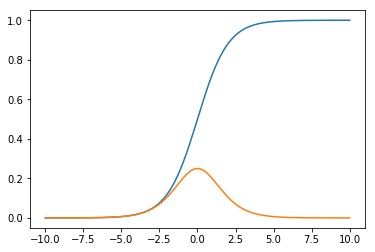

In [3]:
segedX = np.linspace(-10, 10, 200) #létrehoz 200 pontot -6 és 6 között
plt.plot(segedX, activation(segedX)) #x és y tengely
plt.plot(segedX, dactivation(segedX))

In [31]:
# nnetwork = MLP(2,3,1)
class MLP:
    def __init__(self, *args): #ctor self a this
        np.random.seed(123)
        self.shape = args
        n = len(args)
        self.layers = []
        self.layers.append(np.ones(self.shape[0]+1)) #bementi réteg shape[0] + bias
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size, self.layers[i+1].size))) #súlyok i. és i+1 réteg között
        #self.dw = .... #momentumhoz kell
        self.reset()
    
    def reset(self):
        for i in range(len(self.weights)):
            Z = np.random.random((self.layers[i].size, self.layers[i+1].size))
            self.weights[i][...] = (2*Z-1) #skálázás -1,1 -be

    def propagate_forward(self, data):
        self.layers[0][0:-1] = data #az első réteg 0-utolsó előttiig (bias marad 1)
        for i in range(1,len(self.shape)):
            self.layers[i] = activation(np.dot(self.layers[i-1], self.weights[i-1]))

        return self.layers[-1] #utolsó layer

    def propagate_backward(self, target, lrate=0.1):
        deltas = []
        error = -(target-self.layers[-1]) #cost fn alapján
        delta = np.multiply(error, dactivation(np.dot(self.layers[-2], self.weights[-1]))) #error * deriváltf(utolsó összeg) 
        deltas.append(delta)
                            
        # Gradiens kiszámítása a rejtett réteg(ek)ben
        for i in range(len(self.shape)-2, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * dactivation(np.dot(self.layers[i-1], self.weights[i-1]))
            deltas.insert(0, delta)
            
        # Súlyok módosítása
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i]) #ha 1 dimenziós hozzáad egy tengelyt
            delta = np.atleast_2d(deltas[i])
                                
            dw = -lrate * np.dot(layer.T, delta) #momentum módszerhez ezt egészíteni
            self.weights[i] += dw
            
        # Visszatérés a hibával
        return (error ** 2).sum()

def learn(network, X, Y, valid_split, test_split, epochs=5000, lrate=0.01):
    # train-validation-test minták különválasztása
    X_train = X[0:int(X.shape[0]*(1-valid_split-test_split))]
    Y_train = Y[0:int(Y.shape[0]*(1-valid_split-test_split))]
    X_valid = X[int(X.shape[0]*(1-valid_split-test_split)) : int(X.shape[0]*(1-test_split))]
    Y_valid = Y[int(Y.shape[0]*(1-valid_split-test_split)) : int(Y.shape[0]*(1-test_split))]
    X_test  = X[int(X.shape[0]*(1-test_split)):]
    Y_test  = Y[int(Y.shape[0]*(1-test_split)):]
    
    # standardizálás
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_valid = scaler.transform(X_valid)
    X_test  = scaler.transform(X_test)
    
    # shuffle
    randperm = np.random.permutation(len(X_train))
    X_train, Y_train = X_train[randperm], Y_train[randperm]

    # Tanítási fázis, epoch-szor megyünk át 1-1 véltelenszerűen kiválasztott mintán.
    for i in range(epochs):
        train_err = 0
        for k in range(X_train.shape[0]):
            network.propagate_forward( X_train[k])
            train_err += network.propagate_backward(Y_train[k], lrate)
            train_err /= X_train.shape[0]

        # validacio
        valid_err = 0
        o_valid = np.zeros(X_valid.shape[0])
        for k in range(X_valid.shape[0]):
            o_valid[k] = network.propagate_forward( X_valid[k] )
            valid_err += (o_valid[k] - Y_valid[k])**2
        valid_err /= Y_valid.shape[0]
                                
        print("%d epoch, train_err: %.4f, valid_err: %.4f" % (i,train_err,valid_err))
    # Tesztelési fázis
    test_err = 0
    o_test = np.zeros(X_test.shape[0])
    for k in range(X_test.shape[0]):
        o_test[k] = network.propagate_forward( X_test[k] )
        print("Predikcio:",o_test[k],"valos:",Y_test[k])
        test_err += (o_test[k] - Y_test[k])**2
    test_err /= Y_test.shape[0] 
        #fig1=plt.figure()
        #plt.scatter(...

In [41]:
network = MLP(2,2,1)

In [42]:
nb_samples = 200
X = np.zeros((nb_samples,2))
Y = np.zeros((nb_samples))
for i in range(0, nb_samples,4):
    noise = np.random.normal(0,1,8)
    X[i],   Y[i]   = (-2+noise[0], -2+noise[1]), 0
    X[i+1], Y[i+1] = ( 2+noise[2], -2+noise[3]), 1
    X[i+2], Y[i+2] = (-2+noise[4],  2+noise[5]), 1
    X[i+3], Y[i+3] = ( 2+noise[6],  2+noise[7]), 0

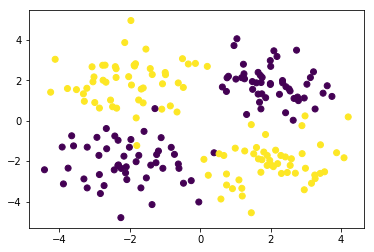

In [43]:
plt.scatter(X[:,0], X[:,1], c = Y[:])

In [44]:
network.reset()
learn(network,X,Y,0.2,0.01)

0 epoch, train_err: 0.0022, valid_err: 0.2558
1 epoch, train_err: 0.0021, valid_err: 0.2550
2 epoch, train_err: 0.0021, valid_err: 0.2544
3 epoch, train_err: 0.0021, valid_err: 0.2538
4 epoch, train_err: 0.0020, valid_err: 0.2534
5 epoch, train_err: 0.0020, valid_err: 0.2530
6 epoch, train_err: 0.0020, valid_err: 0.2526
7 epoch, train_err: 0.0020, valid_err: 0.2524
8 epoch, train_err: 0.0019, valid_err: 0.2521
9 epoch, train_err: 0.0019, valid_err: 0.2519
10 epoch, train_err: 0.0019, valid_err: 0.2517
11 epoch, train_err: 0.0019, valid_err: 0.2516
12 epoch, train_err: 0.0019, valid_err: 0.2514
13 epoch, train_err: 0.0019, valid_err: 0.2513
14 epoch, train_err: 0.0019, valid_err: 0.2512
15 epoch, train_err: 0.0018, valid_err: 0.2511
16 epoch, train_err: 0.0018, valid_err: 0.2510
17 epoch, train_err: 0.0018, valid_err: 0.2510
18 epoch, train_err: 0.0018, valid_err: 0.2509
19 epoch, train_err: 0.0018, valid_err: 0.2508
20 epoch, train_err: 0.0018, valid_err: 0.2508
21 epoch, train_err: 0.

186 epoch, train_err: 0.0018, valid_err: 0.2440
187 epoch, train_err: 0.0018, valid_err: 0.2439
188 epoch, train_err: 0.0018, valid_err: 0.2438
189 epoch, train_err: 0.0018, valid_err: 0.2437
190 epoch, train_err: 0.0018, valid_err: 0.2436
191 epoch, train_err: 0.0018, valid_err: 0.2436
192 epoch, train_err: 0.0018, valid_err: 0.2435
193 epoch, train_err: 0.0018, valid_err: 0.2434
194 epoch, train_err: 0.0018, valid_err: 0.2433
195 epoch, train_err: 0.0018, valid_err: 0.2432
196 epoch, train_err: 0.0018, valid_err: 0.2431
197 epoch, train_err: 0.0018, valid_err: 0.2430
198 epoch, train_err: 0.0018, valid_err: 0.2429
199 epoch, train_err: 0.0018, valid_err: 0.2429
200 epoch, train_err: 0.0018, valid_err: 0.2428
201 epoch, train_err: 0.0018, valid_err: 0.2427
202 epoch, train_err: 0.0018, valid_err: 0.2426
203 epoch, train_err: 0.0018, valid_err: 0.2425
204 epoch, train_err: 0.0018, valid_err: 0.2424
205 epoch, train_err: 0.0018, valid_err: 0.2423
206 epoch, train_err: 0.0018, valid_err:

360 epoch, train_err: 0.0018, valid_err: 0.2144
361 epoch, train_err: 0.0018, valid_err: 0.2142
362 epoch, train_err: 0.0018, valid_err: 0.2140
363 epoch, train_err: 0.0018, valid_err: 0.2138
364 epoch, train_err: 0.0018, valid_err: 0.2135
365 epoch, train_err: 0.0018, valid_err: 0.2133
366 epoch, train_err: 0.0018, valid_err: 0.2131
367 epoch, train_err: 0.0018, valid_err: 0.2129
368 epoch, train_err: 0.0018, valid_err: 0.2126
369 epoch, train_err: 0.0018, valid_err: 0.2124
370 epoch, train_err: 0.0018, valid_err: 0.2122
371 epoch, train_err: 0.0018, valid_err: 0.2119
372 epoch, train_err: 0.0018, valid_err: 0.2117
373 epoch, train_err: 0.0018, valid_err: 0.2115
374 epoch, train_err: 0.0018, valid_err: 0.2113
375 epoch, train_err: 0.0018, valid_err: 0.2111
376 epoch, train_err: 0.0018, valid_err: 0.2108
377 epoch, train_err: 0.0018, valid_err: 0.2106
378 epoch, train_err: 0.0018, valid_err: 0.2104
379 epoch, train_err: 0.0018, valid_err: 0.2102
380 epoch, train_err: 0.0018, valid_err:

538 epoch, train_err: 0.0017, valid_err: 0.1825
539 epoch, train_err: 0.0017, valid_err: 0.1824
540 epoch, train_err: 0.0017, valid_err: 0.1823
541 epoch, train_err: 0.0017, valid_err: 0.1821
542 epoch, train_err: 0.0017, valid_err: 0.1820
543 epoch, train_err: 0.0017, valid_err: 0.1819
544 epoch, train_err: 0.0017, valid_err: 0.1818
545 epoch, train_err: 0.0017, valid_err: 0.1817
546 epoch, train_err: 0.0017, valid_err: 0.1815
547 epoch, train_err: 0.0017, valid_err: 0.1814
548 epoch, train_err: 0.0017, valid_err: 0.1813
549 epoch, train_err: 0.0017, valid_err: 0.1812
550 epoch, train_err: 0.0017, valid_err: 0.1811
551 epoch, train_err: 0.0017, valid_err: 0.1810
552 epoch, train_err: 0.0017, valid_err: 0.1809
553 epoch, train_err: 0.0017, valid_err: 0.1807
554 epoch, train_err: 0.0017, valid_err: 0.1806
555 epoch, train_err: 0.0017, valid_err: 0.1805
556 epoch, train_err: 0.0017, valid_err: 0.1804
557 epoch, train_err: 0.0017, valid_err: 0.1803
558 epoch, train_err: 0.0017, valid_err:

721 epoch, train_err: 0.0017, valid_err: 0.1673
722 epoch, train_err: 0.0017, valid_err: 0.1672
723 epoch, train_err: 0.0017, valid_err: 0.1672
724 epoch, train_err: 0.0017, valid_err: 0.1671
725 epoch, train_err: 0.0017, valid_err: 0.1671
726 epoch, train_err: 0.0017, valid_err: 0.1670
727 epoch, train_err: 0.0017, valid_err: 0.1670
728 epoch, train_err: 0.0017, valid_err: 0.1669
729 epoch, train_err: 0.0017, valid_err: 0.1669
730 epoch, train_err: 0.0017, valid_err: 0.1668
731 epoch, train_err: 0.0017, valid_err: 0.1667
732 epoch, train_err: 0.0017, valid_err: 0.1667
733 epoch, train_err: 0.0017, valid_err: 0.1666
734 epoch, train_err: 0.0017, valid_err: 0.1666
735 epoch, train_err: 0.0017, valid_err: 0.1665
736 epoch, train_err: 0.0017, valid_err: 0.1665
737 epoch, train_err: 0.0017, valid_err: 0.1664
738 epoch, train_err: 0.0017, valid_err: 0.1664
739 epoch, train_err: 0.0017, valid_err: 0.1663
740 epoch, train_err: 0.0017, valid_err: 0.1663
741 epoch, train_err: 0.0017, valid_err:

893 epoch, train_err: 0.0016, valid_err: 0.1602
894 epoch, train_err: 0.0016, valid_err: 0.1602
895 epoch, train_err: 0.0016, valid_err: 0.1602
896 epoch, train_err: 0.0016, valid_err: 0.1601
897 epoch, train_err: 0.0016, valid_err: 0.1601
898 epoch, train_err: 0.0016, valid_err: 0.1601
899 epoch, train_err: 0.0016, valid_err: 0.1600
900 epoch, train_err: 0.0016, valid_err: 0.1600
901 epoch, train_err: 0.0016, valid_err: 0.1600
902 epoch, train_err: 0.0016, valid_err: 0.1599
903 epoch, train_err: 0.0016, valid_err: 0.1599
904 epoch, train_err: 0.0016, valid_err: 0.1599
905 epoch, train_err: 0.0016, valid_err: 0.1599
906 epoch, train_err: 0.0016, valid_err: 0.1598
907 epoch, train_err: 0.0016, valid_err: 0.1598
908 epoch, train_err: 0.0016, valid_err: 0.1598
909 epoch, train_err: 0.0016, valid_err: 0.1597
910 epoch, train_err: 0.0016, valid_err: 0.1597
911 epoch, train_err: 0.0016, valid_err: 0.1597
912 epoch, train_err: 0.0016, valid_err: 0.1597
913 epoch, train_err: 0.0016, valid_err:

1069 epoch, train_err: 0.0016, valid_err: 0.1560
1070 epoch, train_err: 0.0016, valid_err: 0.1560
1071 epoch, train_err: 0.0016, valid_err: 0.1559
1072 epoch, train_err: 0.0016, valid_err: 0.1559
1073 epoch, train_err: 0.0016, valid_err: 0.1559
1074 epoch, train_err: 0.0016, valid_err: 0.1559
1075 epoch, train_err: 0.0016, valid_err: 0.1559
1076 epoch, train_err: 0.0016, valid_err: 0.1559
1077 epoch, train_err: 0.0016, valid_err: 0.1558
1078 epoch, train_err: 0.0016, valid_err: 0.1558
1079 epoch, train_err: 0.0016, valid_err: 0.1558
1080 epoch, train_err: 0.0016, valid_err: 0.1558
1081 epoch, train_err: 0.0016, valid_err: 0.1558
1082 epoch, train_err: 0.0016, valid_err: 0.1557
1083 epoch, train_err: 0.0016, valid_err: 0.1557
1084 epoch, train_err: 0.0016, valid_err: 0.1557
1085 epoch, train_err: 0.0016, valid_err: 0.1557
1086 epoch, train_err: 0.0016, valid_err: 0.1557
1087 epoch, train_err: 0.0016, valid_err: 0.1556
1088 epoch, train_err: 0.0016, valid_err: 0.1556
1089 epoch, train_er

1249 epoch, train_err: 0.0016, valid_err: 0.1532
1250 epoch, train_err: 0.0016, valid_err: 0.1532
1251 epoch, train_err: 0.0016, valid_err: 0.1531
1252 epoch, train_err: 0.0016, valid_err: 0.1531
1253 epoch, train_err: 0.0016, valid_err: 0.1531
1254 epoch, train_err: 0.0016, valid_err: 0.1531
1255 epoch, train_err: 0.0016, valid_err: 0.1531
1256 epoch, train_err: 0.0016, valid_err: 0.1531
1257 epoch, train_err: 0.0016, valid_err: 0.1531
1258 epoch, train_err: 0.0016, valid_err: 0.1531
1259 epoch, train_err: 0.0016, valid_err: 0.1530
1260 epoch, train_err: 0.0016, valid_err: 0.1530
1261 epoch, train_err: 0.0016, valid_err: 0.1530
1262 epoch, train_err: 0.0016, valid_err: 0.1530
1263 epoch, train_err: 0.0016, valid_err: 0.1530
1264 epoch, train_err: 0.0016, valid_err: 0.1530
1265 epoch, train_err: 0.0016, valid_err: 0.1530
1266 epoch, train_err: 0.0016, valid_err: 0.1530
1267 epoch, train_err: 0.0016, valid_err: 0.1529
1268 epoch, train_err: 0.0016, valid_err: 0.1529
1269 epoch, train_er

1429 epoch, train_err: 0.0016, valid_err: 0.1512
1430 epoch, train_err: 0.0016, valid_err: 0.1512
1431 epoch, train_err: 0.0016, valid_err: 0.1512
1432 epoch, train_err: 0.0016, valid_err: 0.1512
1433 epoch, train_err: 0.0016, valid_err: 0.1511
1434 epoch, train_err: 0.0016, valid_err: 0.1511
1435 epoch, train_err: 0.0016, valid_err: 0.1511
1436 epoch, train_err: 0.0016, valid_err: 0.1511
1437 epoch, train_err: 0.0016, valid_err: 0.1511
1438 epoch, train_err: 0.0016, valid_err: 0.1511
1439 epoch, train_err: 0.0016, valid_err: 0.1511
1440 epoch, train_err: 0.0016, valid_err: 0.1511
1441 epoch, train_err: 0.0016, valid_err: 0.1511
1442 epoch, train_err: 0.0016, valid_err: 0.1511
1443 epoch, train_err: 0.0016, valid_err: 0.1510
1444 epoch, train_err: 0.0016, valid_err: 0.1510
1445 epoch, train_err: 0.0016, valid_err: 0.1510
1446 epoch, train_err: 0.0016, valid_err: 0.1510
1447 epoch, train_err: 0.0016, valid_err: 0.1510
1448 epoch, train_err: 0.0016, valid_err: 0.1510
1449 epoch, train_er

1605 epoch, train_err: 0.0016, valid_err: 0.1497
1606 epoch, train_err: 0.0016, valid_err: 0.1497
1607 epoch, train_err: 0.0016, valid_err: 0.1497
1608 epoch, train_err: 0.0016, valid_err: 0.1497
1609 epoch, train_err: 0.0016, valid_err: 0.1497
1610 epoch, train_err: 0.0016, valid_err: 0.1497
1611 epoch, train_err: 0.0016, valid_err: 0.1497
1612 epoch, train_err: 0.0016, valid_err: 0.1497
1613 epoch, train_err: 0.0016, valid_err: 0.1497
1614 epoch, train_err: 0.0016, valid_err: 0.1497
1615 epoch, train_err: 0.0016, valid_err: 0.1496
1616 epoch, train_err: 0.0016, valid_err: 0.1496
1617 epoch, train_err: 0.0016, valid_err: 0.1496
1618 epoch, train_err: 0.0016, valid_err: 0.1496
1619 epoch, train_err: 0.0016, valid_err: 0.1496
1620 epoch, train_err: 0.0016, valid_err: 0.1496
1621 epoch, train_err: 0.0016, valid_err: 0.1496
1622 epoch, train_err: 0.0016, valid_err: 0.1496
1623 epoch, train_err: 0.0016, valid_err: 0.1496
1624 epoch, train_err: 0.0016, valid_err: 0.1496
1625 epoch, train_er

1780 epoch, train_err: 0.0016, valid_err: 0.1486
1781 epoch, train_err: 0.0016, valid_err: 0.1486
1782 epoch, train_err: 0.0016, valid_err: 0.1486
1783 epoch, train_err: 0.0016, valid_err: 0.1486
1784 epoch, train_err: 0.0016, valid_err: 0.1485
1785 epoch, train_err: 0.0016, valid_err: 0.1485
1786 epoch, train_err: 0.0016, valid_err: 0.1485
1787 epoch, train_err: 0.0016, valid_err: 0.1485
1788 epoch, train_err: 0.0016, valid_err: 0.1485
1789 epoch, train_err: 0.0016, valid_err: 0.1485
1790 epoch, train_err: 0.0016, valid_err: 0.1485
1791 epoch, train_err: 0.0016, valid_err: 0.1485
1792 epoch, train_err: 0.0016, valid_err: 0.1485
1793 epoch, train_err: 0.0016, valid_err: 0.1485
1794 epoch, train_err: 0.0016, valid_err: 0.1485
1795 epoch, train_err: 0.0016, valid_err: 0.1485
1796 epoch, train_err: 0.0016, valid_err: 0.1485
1797 epoch, train_err: 0.0016, valid_err: 0.1485
1798 epoch, train_err: 0.0016, valid_err: 0.1485
1799 epoch, train_err: 0.0016, valid_err: 0.1485
1800 epoch, train_er

1954 epoch, train_err: 0.0016, valid_err: 0.1476
1955 epoch, train_err: 0.0016, valid_err: 0.1476
1956 epoch, train_err: 0.0016, valid_err: 0.1476
1957 epoch, train_err: 0.0016, valid_err: 0.1476
1958 epoch, train_err: 0.0016, valid_err: 0.1476
1959 epoch, train_err: 0.0016, valid_err: 0.1476
1960 epoch, train_err: 0.0016, valid_err: 0.1476
1961 epoch, train_err: 0.0016, valid_err: 0.1476
1962 epoch, train_err: 0.0016, valid_err: 0.1476
1963 epoch, train_err: 0.0016, valid_err: 0.1476
1964 epoch, train_err: 0.0016, valid_err: 0.1476
1965 epoch, train_err: 0.0016, valid_err: 0.1476
1966 epoch, train_err: 0.0016, valid_err: 0.1476
1967 epoch, train_err: 0.0016, valid_err: 0.1476
1968 epoch, train_err: 0.0016, valid_err: 0.1476
1969 epoch, train_err: 0.0016, valid_err: 0.1476
1970 epoch, train_err: 0.0016, valid_err: 0.1476
1971 epoch, train_err: 0.0016, valid_err: 0.1476
1972 epoch, train_err: 0.0016, valid_err: 0.1476
1973 epoch, train_err: 0.0016, valid_err: 0.1475
1974 epoch, train_er

2130 epoch, train_err: 0.0016, valid_err: 0.1469
2131 epoch, train_err: 0.0016, valid_err: 0.1468
2132 epoch, train_err: 0.0016, valid_err: 0.1468
2133 epoch, train_err: 0.0016, valid_err: 0.1468
2134 epoch, train_err: 0.0016, valid_err: 0.1468
2135 epoch, train_err: 0.0016, valid_err: 0.1468
2136 epoch, train_err: 0.0016, valid_err: 0.1468
2137 epoch, train_err: 0.0016, valid_err: 0.1468
2138 epoch, train_err: 0.0016, valid_err: 0.1468
2139 epoch, train_err: 0.0016, valid_err: 0.1468
2140 epoch, train_err: 0.0016, valid_err: 0.1468
2141 epoch, train_err: 0.0016, valid_err: 0.1468
2142 epoch, train_err: 0.0016, valid_err: 0.1468
2143 epoch, train_err: 0.0016, valid_err: 0.1468
2144 epoch, train_err: 0.0016, valid_err: 0.1468
2145 epoch, train_err: 0.0016, valid_err: 0.1468
2146 epoch, train_err: 0.0016, valid_err: 0.1468
2147 epoch, train_err: 0.0016, valid_err: 0.1468
2148 epoch, train_err: 0.0016, valid_err: 0.1468
2149 epoch, train_err: 0.0016, valid_err: 0.1468
2150 epoch, train_er

2305 epoch, train_err: 0.0016, valid_err: 0.1462
2306 epoch, train_err: 0.0016, valid_err: 0.1462
2307 epoch, train_err: 0.0016, valid_err: 0.1462
2308 epoch, train_err: 0.0016, valid_err: 0.1462
2309 epoch, train_err: 0.0016, valid_err: 0.1462
2310 epoch, train_err: 0.0016, valid_err: 0.1462
2311 epoch, train_err: 0.0016, valid_err: 0.1462
2312 epoch, train_err: 0.0016, valid_err: 0.1462
2313 epoch, train_err: 0.0016, valid_err: 0.1462
2314 epoch, train_err: 0.0016, valid_err: 0.1462
2315 epoch, train_err: 0.0016, valid_err: 0.1462
2316 epoch, train_err: 0.0016, valid_err: 0.1462
2317 epoch, train_err: 0.0016, valid_err: 0.1461
2318 epoch, train_err: 0.0016, valid_err: 0.1461
2319 epoch, train_err: 0.0016, valid_err: 0.1461
2320 epoch, train_err: 0.0016, valid_err: 0.1461
2321 epoch, train_err: 0.0016, valid_err: 0.1461
2322 epoch, train_err: 0.0016, valid_err: 0.1461
2323 epoch, train_err: 0.0016, valid_err: 0.1461
2324 epoch, train_err: 0.0016, valid_err: 0.1461
2325 epoch, train_er

2475 epoch, train_err: 0.0016, valid_err: 0.1456
2476 epoch, train_err: 0.0016, valid_err: 0.1456
2477 epoch, train_err: 0.0016, valid_err: 0.1456
2478 epoch, train_err: 0.0016, valid_err: 0.1456
2479 epoch, train_err: 0.0016, valid_err: 0.1456
2480 epoch, train_err: 0.0016, valid_err: 0.1456
2481 epoch, train_err: 0.0016, valid_err: 0.1456
2482 epoch, train_err: 0.0016, valid_err: 0.1456
2483 epoch, train_err: 0.0016, valid_err: 0.1456
2484 epoch, train_err: 0.0016, valid_err: 0.1456
2485 epoch, train_err: 0.0016, valid_err: 0.1456
2486 epoch, train_err: 0.0016, valid_err: 0.1456
2487 epoch, train_err: 0.0016, valid_err: 0.1456
2488 epoch, train_err: 0.0016, valid_err: 0.1456
2489 epoch, train_err: 0.0016, valid_err: 0.1456
2490 epoch, train_err: 0.0016, valid_err: 0.1456
2491 epoch, train_err: 0.0016, valid_err: 0.1456
2492 epoch, train_err: 0.0016, valid_err: 0.1456
2493 epoch, train_err: 0.0016, valid_err: 0.1456
2494 epoch, train_err: 0.0016, valid_err: 0.1456
2495 epoch, train_er

2645 epoch, train_err: 0.0016, valid_err: 0.1451
2646 epoch, train_err: 0.0016, valid_err: 0.1451
2647 epoch, train_err: 0.0016, valid_err: 0.1451
2648 epoch, train_err: 0.0016, valid_err: 0.1451
2649 epoch, train_err: 0.0016, valid_err: 0.1451
2650 epoch, train_err: 0.0016, valid_err: 0.1451
2651 epoch, train_err: 0.0016, valid_err: 0.1451
2652 epoch, train_err: 0.0016, valid_err: 0.1451
2653 epoch, train_err: 0.0016, valid_err: 0.1451
2654 epoch, train_err: 0.0016, valid_err: 0.1451
2655 epoch, train_err: 0.0016, valid_err: 0.1451
2656 epoch, train_err: 0.0016, valid_err: 0.1451
2657 epoch, train_err: 0.0016, valid_err: 0.1451
2658 epoch, train_err: 0.0016, valid_err: 0.1451
2659 epoch, train_err: 0.0016, valid_err: 0.1451
2660 epoch, train_err: 0.0016, valid_err: 0.1451
2661 epoch, train_err: 0.0016, valid_err: 0.1451
2662 epoch, train_err: 0.0016, valid_err: 0.1451
2663 epoch, train_err: 0.0016, valid_err: 0.1451
2664 epoch, train_err: 0.0016, valid_err: 0.1451
2665 epoch, train_er

2817 epoch, train_err: 0.0016, valid_err: 0.1447
2818 epoch, train_err: 0.0016, valid_err: 0.1447
2819 epoch, train_err: 0.0016, valid_err: 0.1447
2820 epoch, train_err: 0.0016, valid_err: 0.1447
2821 epoch, train_err: 0.0016, valid_err: 0.1447
2822 epoch, train_err: 0.0016, valid_err: 0.1447
2823 epoch, train_err: 0.0016, valid_err: 0.1447
2824 epoch, train_err: 0.0016, valid_err: 0.1447
2825 epoch, train_err: 0.0016, valid_err: 0.1447
2826 epoch, train_err: 0.0016, valid_err: 0.1447
2827 epoch, train_err: 0.0016, valid_err: 0.1447
2828 epoch, train_err: 0.0016, valid_err: 0.1447
2829 epoch, train_err: 0.0016, valid_err: 0.1447
2830 epoch, train_err: 0.0016, valid_err: 0.1447
2831 epoch, train_err: 0.0016, valid_err: 0.1447
2832 epoch, train_err: 0.0016, valid_err: 0.1447
2833 epoch, train_err: 0.0016, valid_err: 0.1447
2834 epoch, train_err: 0.0016, valid_err: 0.1447
2835 epoch, train_err: 0.0016, valid_err: 0.1447
2836 epoch, train_err: 0.0016, valid_err: 0.1447
2837 epoch, train_er

2994 epoch, train_err: 0.0016, valid_err: 0.1443
2995 epoch, train_err: 0.0016, valid_err: 0.1443
2996 epoch, train_err: 0.0016, valid_err: 0.1443
2997 epoch, train_err: 0.0016, valid_err: 0.1443
2998 epoch, train_err: 0.0016, valid_err: 0.1443
2999 epoch, train_err: 0.0016, valid_err: 0.1443
3000 epoch, train_err: 0.0016, valid_err: 0.1443
3001 epoch, train_err: 0.0016, valid_err: 0.1443
3002 epoch, train_err: 0.0016, valid_err: 0.1443
3003 epoch, train_err: 0.0016, valid_err: 0.1443
3004 epoch, train_err: 0.0016, valid_err: 0.1443
3005 epoch, train_err: 0.0016, valid_err: 0.1443
3006 epoch, train_err: 0.0016, valid_err: 0.1443
3007 epoch, train_err: 0.0016, valid_err: 0.1443
3008 epoch, train_err: 0.0016, valid_err: 0.1443
3009 epoch, train_err: 0.0016, valid_err: 0.1443
3010 epoch, train_err: 0.0016, valid_err: 0.1443
3011 epoch, train_err: 0.0016, valid_err: 0.1443
3012 epoch, train_err: 0.0016, valid_err: 0.1443
3013 epoch, train_err: 0.0016, valid_err: 0.1443
3014 epoch, train_er

3170 epoch, train_err: 0.0016, valid_err: 0.1440
3171 epoch, train_err: 0.0016, valid_err: 0.1440
3172 epoch, train_err: 0.0016, valid_err: 0.1440
3173 epoch, train_err: 0.0016, valid_err: 0.1440
3174 epoch, train_err: 0.0016, valid_err: 0.1440
3175 epoch, train_err: 0.0016, valid_err: 0.1439
3176 epoch, train_err: 0.0016, valid_err: 0.1439
3177 epoch, train_err: 0.0016, valid_err: 0.1439
3178 epoch, train_err: 0.0016, valid_err: 0.1439
3179 epoch, train_err: 0.0016, valid_err: 0.1439
3180 epoch, train_err: 0.0016, valid_err: 0.1439
3181 epoch, train_err: 0.0016, valid_err: 0.1439
3182 epoch, train_err: 0.0016, valid_err: 0.1439
3183 epoch, train_err: 0.0016, valid_err: 0.1439
3184 epoch, train_err: 0.0016, valid_err: 0.1439
3185 epoch, train_err: 0.0016, valid_err: 0.1439
3186 epoch, train_err: 0.0016, valid_err: 0.1439
3187 epoch, train_err: 0.0016, valid_err: 0.1439
3188 epoch, train_err: 0.0016, valid_err: 0.1439
3189 epoch, train_err: 0.0016, valid_err: 0.1439
3190 epoch, train_er

3339 epoch, train_err: 0.0016, valid_err: 0.1437
3340 epoch, train_err: 0.0016, valid_err: 0.1436
3341 epoch, train_err: 0.0016, valid_err: 0.1436
3342 epoch, train_err: 0.0016, valid_err: 0.1436
3343 epoch, train_err: 0.0016, valid_err: 0.1436
3344 epoch, train_err: 0.0016, valid_err: 0.1436
3345 epoch, train_err: 0.0016, valid_err: 0.1436
3346 epoch, train_err: 0.0016, valid_err: 0.1436
3347 epoch, train_err: 0.0016, valid_err: 0.1436
3348 epoch, train_err: 0.0016, valid_err: 0.1436
3349 epoch, train_err: 0.0016, valid_err: 0.1436
3350 epoch, train_err: 0.0016, valid_err: 0.1436
3351 epoch, train_err: 0.0016, valid_err: 0.1436
3352 epoch, train_err: 0.0016, valid_err: 0.1436
3353 epoch, train_err: 0.0016, valid_err: 0.1436
3354 epoch, train_err: 0.0016, valid_err: 0.1436
3355 epoch, train_err: 0.0016, valid_err: 0.1436
3356 epoch, train_err: 0.0016, valid_err: 0.1436
3357 epoch, train_err: 0.0016, valid_err: 0.1436
3358 epoch, train_err: 0.0016, valid_err: 0.1436
3359 epoch, train_er

3517 epoch, train_err: 0.0016, valid_err: 0.1434
3518 epoch, train_err: 0.0016, valid_err: 0.1434
3519 epoch, train_err: 0.0016, valid_err: 0.1434
3520 epoch, train_err: 0.0016, valid_err: 0.1434
3521 epoch, train_err: 0.0016, valid_err: 0.1434
3522 epoch, train_err: 0.0016, valid_err: 0.1433
3523 epoch, train_err: 0.0016, valid_err: 0.1433
3524 epoch, train_err: 0.0016, valid_err: 0.1433
3525 epoch, train_err: 0.0016, valid_err: 0.1433
3526 epoch, train_err: 0.0016, valid_err: 0.1433
3527 epoch, train_err: 0.0016, valid_err: 0.1433
3528 epoch, train_err: 0.0016, valid_err: 0.1433
3529 epoch, train_err: 0.0016, valid_err: 0.1433
3530 epoch, train_err: 0.0016, valid_err: 0.1433
3531 epoch, train_err: 0.0016, valid_err: 0.1433
3532 epoch, train_err: 0.0016, valid_err: 0.1433
3533 epoch, train_err: 0.0016, valid_err: 0.1433
3534 epoch, train_err: 0.0016, valid_err: 0.1433
3535 epoch, train_err: 0.0016, valid_err: 0.1433
3536 epoch, train_err: 0.0016, valid_err: 0.1433
3537 epoch, train_er

3686 epoch, train_err: 0.0016, valid_err: 0.1431
3687 epoch, train_err: 0.0016, valid_err: 0.1431
3688 epoch, train_err: 0.0016, valid_err: 0.1431
3689 epoch, train_err: 0.0016, valid_err: 0.1431
3690 epoch, train_err: 0.0016, valid_err: 0.1431
3691 epoch, train_err: 0.0016, valid_err: 0.1431
3692 epoch, train_err: 0.0016, valid_err: 0.1431
3693 epoch, train_err: 0.0016, valid_err: 0.1431
3694 epoch, train_err: 0.0016, valid_err: 0.1431
3695 epoch, train_err: 0.0016, valid_err: 0.1431
3696 epoch, train_err: 0.0016, valid_err: 0.1431
3697 epoch, train_err: 0.0016, valid_err: 0.1431
3698 epoch, train_err: 0.0016, valid_err: 0.1431
3699 epoch, train_err: 0.0016, valid_err: 0.1431
3700 epoch, train_err: 0.0016, valid_err: 0.1431
3701 epoch, train_err: 0.0016, valid_err: 0.1431
3702 epoch, train_err: 0.0016, valid_err: 0.1431
3703 epoch, train_err: 0.0016, valid_err: 0.1431
3704 epoch, train_err: 0.0016, valid_err: 0.1431
3705 epoch, train_err: 0.0016, valid_err: 0.1431
3706 epoch, train_er

3855 epoch, train_err: 0.0016, valid_err: 0.1429
3856 epoch, train_err: 0.0016, valid_err: 0.1429
3857 epoch, train_err: 0.0016, valid_err: 0.1429
3858 epoch, train_err: 0.0016, valid_err: 0.1429
3859 epoch, train_err: 0.0016, valid_err: 0.1429
3860 epoch, train_err: 0.0016, valid_err: 0.1429
3861 epoch, train_err: 0.0016, valid_err: 0.1429
3862 epoch, train_err: 0.0016, valid_err: 0.1429
3863 epoch, train_err: 0.0016, valid_err: 0.1429
3864 epoch, train_err: 0.0016, valid_err: 0.1429
3865 epoch, train_err: 0.0016, valid_err: 0.1429
3866 epoch, train_err: 0.0016, valid_err: 0.1429
3867 epoch, train_err: 0.0016, valid_err: 0.1429
3868 epoch, train_err: 0.0016, valid_err: 0.1429
3869 epoch, train_err: 0.0016, valid_err: 0.1428
3870 epoch, train_err: 0.0016, valid_err: 0.1428
3871 epoch, train_err: 0.0016, valid_err: 0.1428
3872 epoch, train_err: 0.0016, valid_err: 0.1428
3873 epoch, train_err: 0.0016, valid_err: 0.1428
3874 epoch, train_err: 0.0016, valid_err: 0.1428
3875 epoch, train_er

4023 epoch, train_err: 0.0016, valid_err: 0.1427
4024 epoch, train_err: 0.0016, valid_err: 0.1427
4025 epoch, train_err: 0.0016, valid_err: 0.1427
4026 epoch, train_err: 0.0016, valid_err: 0.1426
4027 epoch, train_err: 0.0016, valid_err: 0.1426
4028 epoch, train_err: 0.0016, valid_err: 0.1426
4029 epoch, train_err: 0.0016, valid_err: 0.1426
4030 epoch, train_err: 0.0016, valid_err: 0.1426
4031 epoch, train_err: 0.0016, valid_err: 0.1426
4032 epoch, train_err: 0.0016, valid_err: 0.1426
4033 epoch, train_err: 0.0016, valid_err: 0.1426
4034 epoch, train_err: 0.0016, valid_err: 0.1426
4035 epoch, train_err: 0.0016, valid_err: 0.1426
4036 epoch, train_err: 0.0016, valid_err: 0.1426
4037 epoch, train_err: 0.0016, valid_err: 0.1426
4038 epoch, train_err: 0.0016, valid_err: 0.1426
4039 epoch, train_err: 0.0016, valid_err: 0.1426
4040 epoch, train_err: 0.0016, valid_err: 0.1426
4041 epoch, train_err: 0.0016, valid_err: 0.1426
4042 epoch, train_err: 0.0016, valid_err: 0.1426
4043 epoch, train_er

4205 epoch, train_err: 0.0016, valid_err: 0.1424
4206 epoch, train_err: 0.0016, valid_err: 0.1424
4207 epoch, train_err: 0.0016, valid_err: 0.1424
4208 epoch, train_err: 0.0016, valid_err: 0.1424
4209 epoch, train_err: 0.0016, valid_err: 0.1424
4210 epoch, train_err: 0.0016, valid_err: 0.1424
4211 epoch, train_err: 0.0016, valid_err: 0.1424
4212 epoch, train_err: 0.0016, valid_err: 0.1424
4213 epoch, train_err: 0.0016, valid_err: 0.1424
4214 epoch, train_err: 0.0016, valid_err: 0.1424
4215 epoch, train_err: 0.0016, valid_err: 0.1424
4216 epoch, train_err: 0.0016, valid_err: 0.1424
4217 epoch, train_err: 0.0016, valid_err: 0.1424
4218 epoch, train_err: 0.0016, valid_err: 0.1424
4219 epoch, train_err: 0.0016, valid_err: 0.1424
4220 epoch, train_err: 0.0016, valid_err: 0.1424
4221 epoch, train_err: 0.0016, valid_err: 0.1424
4222 epoch, train_err: 0.0016, valid_err: 0.1424
4223 epoch, train_err: 0.0016, valid_err: 0.1424
4224 epoch, train_err: 0.0016, valid_err: 0.1424
4225 epoch, train_er

4374 epoch, train_err: 0.0016, valid_err: 0.1423
4375 epoch, train_err: 0.0016, valid_err: 0.1423
4376 epoch, train_err: 0.0016, valid_err: 0.1422
4377 epoch, train_err: 0.0016, valid_err: 0.1422
4378 epoch, train_err: 0.0016, valid_err: 0.1422
4379 epoch, train_err: 0.0016, valid_err: 0.1422
4380 epoch, train_err: 0.0016, valid_err: 0.1422
4381 epoch, train_err: 0.0016, valid_err: 0.1422
4382 epoch, train_err: 0.0016, valid_err: 0.1422
4383 epoch, train_err: 0.0016, valid_err: 0.1422
4384 epoch, train_err: 0.0016, valid_err: 0.1422
4385 epoch, train_err: 0.0016, valid_err: 0.1422
4386 epoch, train_err: 0.0016, valid_err: 0.1422
4387 epoch, train_err: 0.0016, valid_err: 0.1422
4388 epoch, train_err: 0.0016, valid_err: 0.1422
4389 epoch, train_err: 0.0016, valid_err: 0.1422
4390 epoch, train_err: 0.0016, valid_err: 0.1422
4391 epoch, train_err: 0.0016, valid_err: 0.1422
4392 epoch, train_err: 0.0016, valid_err: 0.1422
4393 epoch, train_err: 0.0016, valid_err: 0.1422
4394 epoch, train_er

4547 epoch, train_err: 0.0016, valid_err: 0.1421
4548 epoch, train_err: 0.0016, valid_err: 0.1421
4549 epoch, train_err: 0.0016, valid_err: 0.1421
4550 epoch, train_err: 0.0016, valid_err: 0.1421
4551 epoch, train_err: 0.0016, valid_err: 0.1421
4552 epoch, train_err: 0.0016, valid_err: 0.1421
4553 epoch, train_err: 0.0016, valid_err: 0.1421
4554 epoch, train_err: 0.0016, valid_err: 0.1421
4555 epoch, train_err: 0.0016, valid_err: 0.1421
4556 epoch, train_err: 0.0016, valid_err: 0.1421
4557 epoch, train_err: 0.0016, valid_err: 0.1421
4558 epoch, train_err: 0.0016, valid_err: 0.1421
4559 epoch, train_err: 0.0016, valid_err: 0.1421
4560 epoch, train_err: 0.0016, valid_err: 0.1421
4561 epoch, train_err: 0.0016, valid_err: 0.1421
4562 epoch, train_err: 0.0016, valid_err: 0.1421
4563 epoch, train_err: 0.0016, valid_err: 0.1421
4564 epoch, train_err: 0.0016, valid_err: 0.1421
4565 epoch, train_err: 0.0016, valid_err: 0.1421
4566 epoch, train_err: 0.0016, valid_err: 0.1421
4567 epoch, train_er

4724 epoch, train_err: 0.0016, valid_err: 0.1419
4725 epoch, train_err: 0.0016, valid_err: 0.1419
4726 epoch, train_err: 0.0016, valid_err: 0.1419
4727 epoch, train_err: 0.0016, valid_err: 0.1419
4728 epoch, train_err: 0.0016, valid_err: 0.1419
4729 epoch, train_err: 0.0016, valid_err: 0.1419
4730 epoch, train_err: 0.0016, valid_err: 0.1419
4731 epoch, train_err: 0.0016, valid_err: 0.1419
4732 epoch, train_err: 0.0016, valid_err: 0.1419
4733 epoch, train_err: 0.0016, valid_err: 0.1419
4734 epoch, train_err: 0.0016, valid_err: 0.1419
4735 epoch, train_err: 0.0016, valid_err: 0.1419
4736 epoch, train_err: 0.0016, valid_err: 0.1419
4737 epoch, train_err: 0.0016, valid_err: 0.1419
4738 epoch, train_err: 0.0016, valid_err: 0.1419
4739 epoch, train_err: 0.0016, valid_err: 0.1419
4740 epoch, train_err: 0.0016, valid_err: 0.1419
4741 epoch, train_err: 0.0016, valid_err: 0.1419
4742 epoch, train_err: 0.0016, valid_err: 0.1419
4743 epoch, train_err: 0.0016, valid_err: 0.1419
4744 epoch, train_er

4900 epoch, train_err: 0.0016, valid_err: 0.1417
4901 epoch, train_err: 0.0016, valid_err: 0.1417
4902 epoch, train_err: 0.0016, valid_err: 0.1417
4903 epoch, train_err: 0.0016, valid_err: 0.1417
4904 epoch, train_err: 0.0016, valid_err: 0.1417
4905 epoch, train_err: 0.0016, valid_err: 0.1417
4906 epoch, train_err: 0.0016, valid_err: 0.1417
4907 epoch, train_err: 0.0016, valid_err: 0.1417
4908 epoch, train_err: 0.0016, valid_err: 0.1417
4909 epoch, train_err: 0.0016, valid_err: 0.1417
4910 epoch, train_err: 0.0016, valid_err: 0.1417
4911 epoch, train_err: 0.0016, valid_err: 0.1417
4912 epoch, train_err: 0.0016, valid_err: 0.1417
4913 epoch, train_err: 0.0016, valid_err: 0.1417
4914 epoch, train_err: 0.0016, valid_err: 0.1417
4915 epoch, train_err: 0.0016, valid_err: 0.1417
4916 epoch, train_err: 0.0016, valid_err: 0.1417
4917 epoch, train_err: 0.0016, valid_err: 0.1417
4918 epoch, train_err: 0.0016, valid_err: 0.1417
4919 epoch, train_err: 0.0016, valid_err: 0.1417
4920 epoch, train_er